In [154]:
#install PyG in google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz

import numpy as np
import torch as th
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

from pyg_classifier.data import CGDataset


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)



Pytorch Version 1.10.2
Cuda is available: True
Using device: cuda


TODO:
*  figure out how PyG returns graph level predictions (shape of prediction doesnt match shape of labels per batch)

In [155]:
#Model

import torch.nn.functional as F
import torch_geometric.nn as tgnn

#Coarse Grain RNA Classifier Model
class CG_Classifier(th.nn.Module):
    def __init__(self):
        self.c = 0
        super(CG_Classifier, self).__init__()
        
        self.conv1 = tgnn.TAGConv(18, 200, K=2)
        self.conv2 = tgnn.TAGConv(200, 200, K=2)
        self.conv3 = tgnn.TAGConv(200, 200, K=2)
        self.conv4 = tgnn.TAGConv(200, 200, K=2)
        self.conv5 = tgnn.TAGConv(200, 50, K=2)

        self.sage_conv1 = tgnn.SAGEConv(50, 100)
        self.sage_conv2 = tgnn.SAGEConv(100, 100)
        self.sage_conv3 = tgnn.SAGEConv(100, 100)
        self.sage_conv4 = tgnn.SAGEConv(100, 100)
        self.sage_conv5 = tgnn.SAGEConv(100, 50)
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(50, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 1)
        )
        
    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = self.conv4(x, edge_index)
        x = F.elu(x)
        x = self.conv5(x, edge_index)
        x = F.elu(x)

        

        x = self.sage_conv1(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv2(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv3(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv4(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv5(x, edge_index)
        x = F.elu(x)

        x = tgnn.global_mean_pool(x, batch) #self.readout(x, edge_index)
        
        return self.classify(x)

In [164]:
#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt"

training_dataset = CGDataset(training_dir, rmsd_list)

In [165]:
#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"

val_dataset = CGDataset(val_dir, val_rmsd)

Processing...
Done!


Epoch 0: Training loss 8.6341, Validation loss 25.7221, learning rate: 0.00100
Epoch 5: Training loss 4.3328, Validation loss 16.5228, learning rate: 0.00100
Epoch 10: Training loss 4.1634, Validation loss 16.6883, learning rate: 0.00100
Epoch 15: Training loss 3.9589, Validation loss 17.1845, learning rate: 0.00100
Epoch 20: Training loss 3.6021, Validation loss 16.4816, learning rate: 0.00100
Epoch 25: Training loss 3.6080, Validation loss 16.9291, learning rate: 0.00099
Epoch 30: Training loss 3.2093, Validation loss 18.0476, learning rate: 0.00099
Epoch 35: Training loss 3.5034, Validation loss 16.5345, learning rate: 0.00099
Epoch 40: Training loss 2.7156, Validation loss 17.0572, learning rate: 0.00098
Epoch 45: Training loss 2.5589, Validation loss 15.5358, learning rate: 0.00098
Epoch 50: Training loss 2.7494, Validation loss 19.1650, learning rate: 0.00097
Epoch 55: Training loss 2.4959, Validation loss 17.9355, learning rate: 0.00097
Epoch 60: Training loss 2.2909, Validation

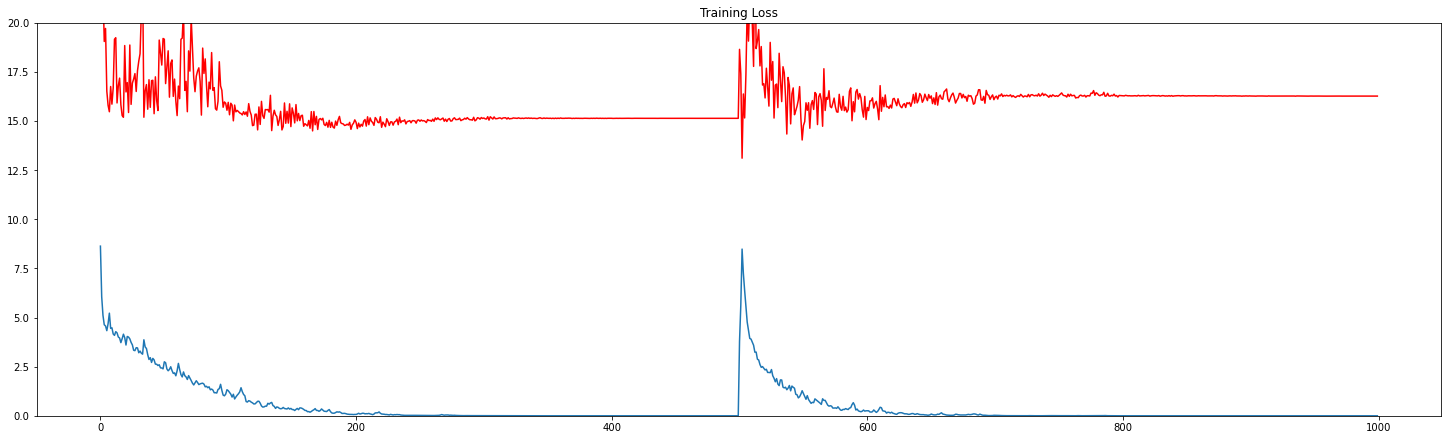

In [166]:
#Training
import time
start = time.perf_counter()

model = CG_Classifier().to(device)

b_size = 64
train_dataloader = DataLoader(training_dataset, batch_size=b_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=b_size)

opt = th.optim.Adam(model.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=500)#, T_mult=2)
model.train()

epochs = 1000

#training setup
epoch_losses = []
val_losses = []
learning_rates = []
for epoch in range(epochs):
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred = model(data)
        loss = F.smooth_l1_loss(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss = 0
    for i, v_data in enumerate(val_dataloader):
        v_data = v_data.to(device)
        val_pred = model(v_data)
        v_loss = F.smooth_l1_loss(th.reshape(val_pred, (-1,)), v_data.y, reduction='mean')
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    
    val_losses.append(val_loss)
    
    
    th.save(model.state_dict(), "pyg_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}, learning rate: {:.5f}".format(epoch, epoch_loss, val_loss, scheduler.get_last_lr()[0]))
        
end = time.perf_counter()

print("Training took {:.2f} hours".format((end - start)/60/60))
print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))

#plot the training run
figure, ax = plt.subplots(layout='constrained', figsize=(20, 6))
ax.plot(epoch_losses)
ax.plot(val_losses, 'r')
plt.title("Training Loss")
ax.set_ybound(lower=0, upper=20)
plt.draw()

In [63]:
#store training run data

file = "pyg_loss_data_2022-02-17.txt"

with open("data/" + file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates))

In [ ]:
#get training run data

file = "pyg_loss_data_2022-02-15.txt"

file_lines = []
with open("data/" + file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]

print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))


Minimum Training Loss 0.0002 in epoch 999
Minimum Validation Loss 13.1550 in epoch 607


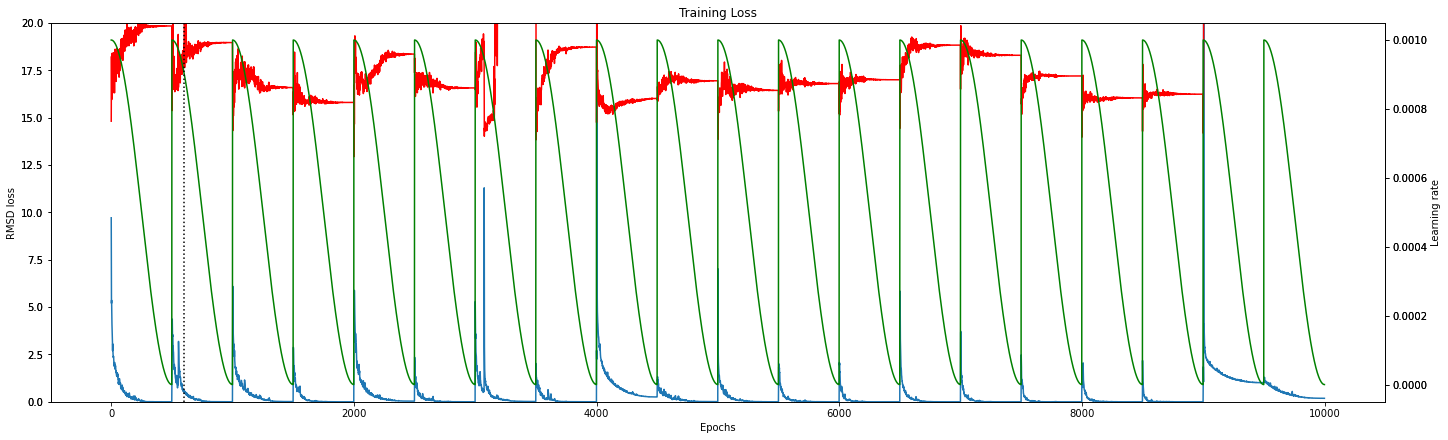

In [145]:
#plot the training run
fig, ax1 = plt.subplots(layout='constrained', figsize=(20, 6))
ax1.secondary_yaxis('left')
ax1.plot(epoch_losses)
ax1.plot(val_losses, 'r')
ax2 = ax1.twinx()
ax2.secondary_yaxis('right')
ax2.plot(learning_rates, 'g')
plt.title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSD loss")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = 600, c = 'black', ls = ':')
#plt.axvline(x = 96, c = 'black', ls = ':')
#plt.axvline(x = 145, c = 'black', ls = ':')
#plt.axvline(x = 190, c = 'black', ls = ':')
#plt.axvline(x = 250, c = 'black', ls = ':')
#plt.axvline(x = 321, c = 'black', ls = ':')
#plt.axvline(x = 404, c = 'black', ls = ':')
plt.draw()

In [139]:
#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"

test_dataset = CGDataset(test_dir, test_rmsd)

test_dataloader = DataLoader(test_dataset)

Processing...
Done!


In [140]:
#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"

st_test_dataset = CGDataset(st_test_dir, st_test_rmsd)

st_test_dataloader = DataLoader(st_test_dataset)

Processing...
Done!


Normal Test Set
tensor([23.4710], device='cuda:0') tensor([[23.3951]], device='cuda:0') 0.07589530944824219
tensor([0.], device='cuda:0') tensor([[103.0402]], device='cuda:0') 103.04022979736328
Mean Test loss: 	 17.7584
Std. Dev. of Test loss:  18.8861
Min loss: 		 0.0759
First Quantile: 	 6.1646
Median: 		 11.1980
Third Quantile: 	 20.5713
Max Loss: 		 103.0402


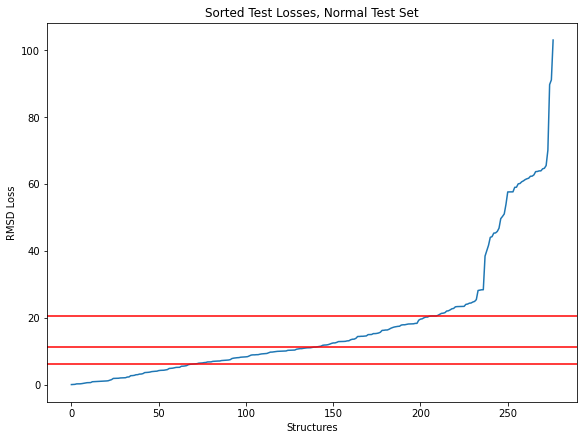

5S rRNA and tRNA Test Set
tensor([19.2860], device='cuda:0') tensor([[19.3007]], device='cuda:0') 0.014734268188476562
tensor([0.], device='cuda:0') tensor([[114.8037]], device='cuda:0') 114.80374908447266
Mean Test loss: 	 8.8823
Std. Dev. of Test loss:  15.8764
Min loss: 		 0.0147
First Quantile: 	 1.8366
Median: 		 3.9895
Third Quantile: 	 7.1819
Max Loss: 		 114.8037


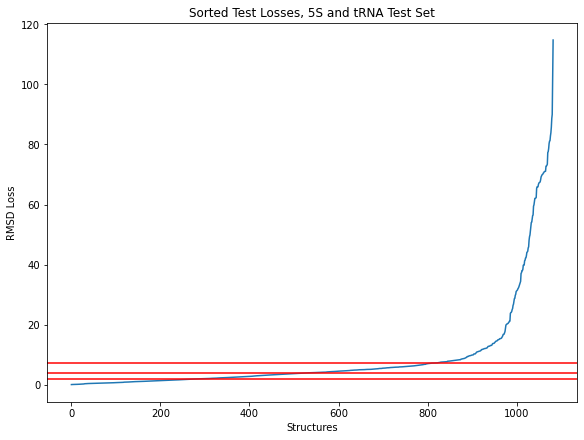

In [146]:
#Test
import math

if "model" not in globals():
    model = CG_Classifier(num_features=3)

model.to(device)

model.load_state_dict(th.load("pyg_model_data/model_epoch5400.pth"))

model.eval()

with th.no_grad():
    for loader in [test_dataloader, st_test_dataloader]:
        max_label = 0
        max_loss = 0
        max_pred = 0
        min_label = math.inf
        min_loss = math.inf
        min_pred = math.inf
        test_losses = []
        for test_graph in loader:
            test_graph = test_graph.to(device)
            test_pred, _, _ = model(test_graph)
            test_loss = F.l1_loss(th.reshape(test_pred, (-1,)), test_graph.y).item() #smooth_l1_loss #(test_pred, test_graph.y).item() #
            test_losses.append(test_loss)
            if test_loss > max_loss:
                max_loss = test_loss
                max_label = test_graph.y
                max_pred = test_pred
            if test_loss < min_loss:
                min_loss = test_loss
                min_label = test_graph.y
                min_pred = test_pred
            if test_pred < 0:
                print(test_graph.y, test_pred)

        if loader == test_dataloader:
            print("Normal Test Set")
        elif loader == st_test_dataloader:
            print("5S rRNA and tRNA Test Set")
        print(min_label, min_pred, min_loss)
        print(max_label, max_pred, max_loss)
        test_mean = np.mean(test_losses)
        test_std = np.std(test_losses)
        test_fq = np.quantile(test_losses, q = 0.25)
        test_median = np.median(test_losses)
        test_tq = np.quantile(test_losses, q = 0.75)
        print("Mean Test loss: \t {:.4f}".format(test_mean))
        print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
        print("Min loss: \t\t {:.4f}".format(min(test_losses)))
        print("First Quantile: \t {:.4f}".format(test_fq))
        print("Median: \t\t {:.4f}".format(test_median))
        print("Third Quantile: \t {:.4f}".format(test_tq))
        print("Max Loss: \t\t {:.4f}".format(max(test_losses)))

        #print(sorted(test_losses)[-5:])

        fig, axs = plt.subplots(layout='constrained', figsize=(8, 6))
        axs.plot(sorted(test_losses))
        #plt.title("Sorted Test Losses")
        if loader == test_dataloader:
            plt.title("Sorted Test Losses, Normal Test Set")
        elif loader == st_test_dataloader:
            plt.title("Sorted Test Losses, 5S and tRNA Test Set")
        plt.ylabel("RMSD Loss")
        plt.xlabel("Structures")
        plt.axhline(y = test_fq, color = 'r')
        plt.axhline(y = test_median, color = 'r')
        plt.axhline(y = test_tq, color = 'r')
        plt.show()